# Grad-CAM

In [1]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange

In [2]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers 
    
    ref : https://github.com/jacobgil/pytorch-grad-cam/blob/a701308935d7bc18ec0659eddc95fd6d3e315fd2/pytorch_grad_cam/activations_and_gradients.py#L1
    """
    def __init__(self, model, target_layers):
        self.model = model
        self.gradients = []
        self.activations = []
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

In [3]:
# config
import torch
import torch.nn as nn

# hyperparameters
class Config:
    gpu_id = 0 if torch.cuda.is_available() else -1
    device = torch.device('cuda:0') # torch.device('cpu') 
    max_seq_len = 100
    train_ratio = .8
    valid_ratio = .1
    hidden_size = 512
    output_size = 1
    num_head = 8
    num_encoder = 12
    use_leakyrelu = True
    dropout_p = .1
    learning_rate = 0.001
    grad_acc = True
    grad_acc_iter = 8

    batch_size = 64
    n_epochs = 2
    
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cuda:0') # torch.device('cpu') 
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
hidden_size = 512
output_size = 1
num_head = 8
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
grad_acc = True
grad_acc_iter = 8

batch_size = 64
n_epochs = 2
    
config = Config()

# dataloader
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from utils import pid_diff_collate_fn

# 1. get Dataset
dataset = ASSIST2009_PID_DIFF(config.max_seq_len, idx=0, config=config)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

# 2. split Dataset
train_size = int( len(dataset) * config.train_ratio * (1 - config.valid_ratio))
valid_size = int( len(dataset) * config.train_ratio * config.valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset = Subset(dataset, range( train_size ))
valid_dataset = Subset(dataset, range( train_size, train_size + valid_size ))
test_dataset = Subset(dataset, range( train_size + valid_size, train_size + valid_size + test_size ))

# 3. get DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size = config.batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = config.batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = config.batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

from models.monacobert_ctt import MonaCoBERT_CTT

model_monaco_ctt = MonaCoBERT_CTT(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p,
).to(device)

model_monaco_ctt_path = '../model_records/0.8089741885505527_8_29_13_28_ctt_model.pth'

model_dict = torch.load(model_monaco_ctt_path)
model_monaco_ctt.load_state_dict(model_dict['model'])

from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

optimizer = Adam(model_monaco_ctt.parameters(), learning_rate)
crit = binary_cross_entropy

In [4]:
target_layers = []
for encoder in model_monaco_ctt.encoder:
    target_layers.extend([encoder.attn.attn_hook_helper, 
                          encoder.attn.conv_hook_helper])
    
gradients_list = []
activations_list = []
valid_sample_list = []

In [5]:
act_and_grad = ActivationsAndGradients(
    model = model_monaco_ctt, 
    target_layers = target_layers,
)

In [6]:
def gradcam_loss(y_hat, correct):
    correct[correct == 0] = -1
    return (y_hat * correct).mean()

In [7]:
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

In [8]:
from tqdm import tqdm

model_monaco_ctt.eval()
for batch_idx, data in tqdm(enumerate(test_loader)):
    act_and_grad.gradients = []
    act_and_grad.activations = []
    
    q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data

    q_seqs = q_seqs.to(device)
    r_seqs = r_seqs.to(device)
    pid_seqs = pid_seqs.to(device)
    diff_seqs = diff_seqs.to(device)
    mask_seqs = mask_seqs.to(device)

    real_seqs = r_seqs.clone()

    mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

    mlm_r_seqs = mlm_r_seqs.to(device)
    mlm_idxs = mlm_idxs.to(device)

    y_hat = model_monaco_ctt(
        q_seqs.long(),
        mlm_r_seqs.long(),
        pid_seqs.long(),
        diff_seqs.long(),
        mask_seqs.long()
    )

    y_hat = y_hat.squeeze()

    y_hat = torch.masked_select(y_hat, mlm_idxs)
    correct = torch.masked_select(real_seqs, mlm_idxs)

    # loss = crit(y_hat, correct)
    loss = gradcam_loss(y_hat, correct)
    loss.backward()
    
    # save the result
    batch = mask_seqs.detach().cpu()
    valid_sample_list.append(mask_seqs.detach().cpu())
    
    gradients_list.append(act_and_grad.gradients)
    activations_list.append(act_and_grad.activations)
    assert len(act_and_grad.gradients) == 24
    # assert len(act_and_grad.gradients) == 5

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
17it [00:15,  1.07it/s]


# visualization : grad-cam

In [9]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

num_encoder = 12
num_head = 8

In [10]:
from copy import deepcopy

grad_attn_layers = {}
grad_conv_layers = {}

for layer_idx in range(num_encoder):
    grad_attn_layers[f'{layer_idx}'] = 0
    grad_conv_layers[f'{layer_idx}'] = 0
    
    for head_idx in range(num_head):
        grad_attn_layers[f'{layer_idx}-{head_idx}'] = 0
        grad_conv_layers[f'{layer_idx}-{head_idx}'] = 0
        
grad_attn_layers_gradcam = deepcopy(grad_attn_layers)
grad_conv_layers_gradcam = deepcopy(grad_conv_layers)

relu = nn.ReLU()
num_samples = 0
for valid_sample, gradients, activations in zip(valid_sample_list, gradients_list, activations_list):
    for seq_idx, seq in tqdm(enumerate(valid_sample)):
        for sample_idx, is_valid_sample in enumerate(seq):
            if bool(is_valid_sample):
                num_samples += 1
                for encoder_idx in range(num_encoder):
                    # grad cam
                    grad_attn = rearrange(gradients[2*encoder_idx], 's i h l -> s i (h l)')[seq_idx, sample_idx]
                    grad_conv = rearrange(gradients[2*encoder_idx+1], 's i h l -> s i (h l)')[seq_idx, sample_idx]

                    acti_attn = rearrange(activations[2*encoder_idx], 's i h l -> s i (h l)')[seq_idx, sample_idx]
                    acti_conv = rearrange(activations[2*encoder_idx+1], 's i h l -> s i (h l)')[seq_idx, sample_idx]
                    
                    denomi = relu(acti_attn * grad_attn).sum() + relu(acti_conv * grad_conv).sum()
                    
                    grad_attn_layers_gradcam[f'{encoder_idx}'] += relu(acti_attn * grad_attn).sum() / denomi
                    grad_conv_layers_gradcam[f'{encoder_idx}'] += relu(acti_conv * grad_conv).sum() / denomi

64it [00:02, 23.25it/s]
64it [00:02, 22.83it/s]
64it [00:02, 24.68it/s]
64it [00:01, 34.99it/s]
64it [00:01, 47.37it/s]
64it [00:01, 56.45it/s]
64it [00:02, 31.28it/s]
64it [00:01, 33.49it/s]
64it [00:06, 10.63it/s]
64it [00:10,  6.35it/s]
64it [00:09,  6.47it/s]
64it [00:10,  6.18it/s]
64it [00:09,  6.40it/s]
64it [00:09,  6.56it/s]
64it [00:10,  6.23it/s]
64it [00:10,  6.10it/s]
57it [00:09,  5.90it/s]


In [11]:
attn_gradcam = []
conv_gradcam = []

for layer_idx in np.arange(0, num_encoder).tolist():
    attn_gradcam.append(grad_attn_layers_gradcam[f'{layer_idx}'].mean())
    conv_gradcam.append(grad_conv_layers_gradcam[f'{layer_idx}'].mean())
    
attn_gradcam = np.array(attn_gradcam)
conv_gradcam = np.array(conv_gradcam)

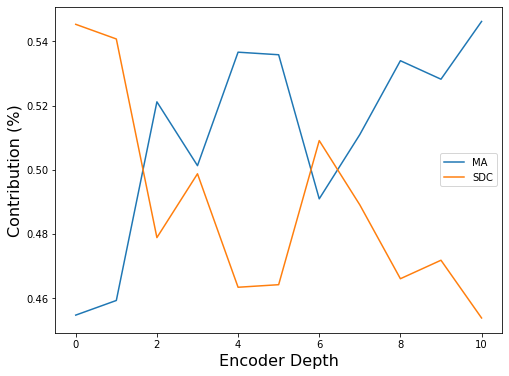

In [13]:
# figure 3-a
plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(attn_gradcam / (attn_gradcam + conv_gradcam), label = 'MA')
plt.plot(conv_gradcam / (attn_gradcam + conv_gradcam), label = 'SDC')
plt.legend()
plt.xlabel('Encoder Depth', fontsize = 16)
plt.ylabel('Contribution (%)', fontsize = 16)
plt.savefig('../model_records/figure_3_a.pdf')